<a href="https://colab.research.google.com/github/olorunfemibabalola/Depression-Tweet-Classifier/blob/main/MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [268]:
# PROJECT: Explainable Depression Risk and Intent Classifier for Tweets
# UNIT: Machine Learning and Applications (Level 7)
# AUTHOR: Olorunfemi
# DESCRIPTION: A Multi-Output Machine Learning system utilizing Multimodal
# Feature Fusion and SHAP explainability to detect depression risk and intent.


LIBRARY SETUP

In [269]:
!pip install shap nltk pandas numpy scikit-learn matplotlib seaborn requests beautifulsoup4

In [270]:
import pandas as pd
import numpy as np
import re
import nltk
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, recall_score, f1_score, accuracy_score


In [271]:
# Download necessary NLTK lexicons (Quietly)
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [272]:
# Configuration for Reproducibility
RANDOM_STATE = 42
MAX_FEATURES = 1000  # For TF-IDF to keep training fast

MODULE 1: DATA ACQUISITION & SYNTHESIS (The "Safety Net")

In [273]:
def generate_synthetic_data(n_samples=500):
    """
    Generates synthetic data if real data is missing.
    Ensures the pipeline runs immediately for reporting/video.
    """
    print("\n⚠️  DATA STATUS: Real CSV not found. Generating SYNTHETIC DATA for demonstration...")
    print("    (This allows you to generate report graphs immediately.)")

    data = {'text': [], 'risk_label': [], 'intent': []}

    # Intent: Cry for Help (High Risk)
    helps = [
        "I can't do this anymore, please someone help.", "Planning to end it tonight.",
        "There is no hope left, I want the pain to stop.", "I feel like I'm drowning.",
        "Goodbye everyone, I can't take this life anymore."
    ]
    # Intent: Venting (Medium/High Risk)
    vents = [
        "So frustrated with everything right now.", "Why is life so exhausting?",
        "Crying in my room again, standard Tuesday.", "My anxiety is through the roof.",
        "I hate how I feel, just needed to say it."
    ]
    # Intent: Loneliness (Medium Risk)
    lonely = [
        "I haven't spoken to a human in days.", "Does anyone else feel invisible?",
        "I miss having friends who care.", "The silence is too loud.",
        "Just sitting here alone again."
    ]
    # Intent: Neutral (Low Risk)
    neutral = [
        "Watching Netflix and chilling.", "Great workout today!",
        "Anyone see the game last night?", "Coffee is life.",
        "Just finished my homework."
    ]

    for _ in range(n_samples // 4):
        data['text'].append(np.random.choice(helps))
        data['risk_label'].append(1)
        data['intent'].append("Cry for Help")

        data['text'].append(np.random.choice(vents))
        data['risk_label'].append(1)
        data['intent'].append("Venting")

        data['text'].append(np.random.choice(lonely))
        data['risk_label'].append(1)
        data['intent'].append("Loneliness")

        data['text'].append(np.random.choice(neutral))
        data['risk_label'].append(0)
        data['intent'].append("Neutral")

    return pd.DataFrame(data)

In [274]:
def load_and_prep_data():
    """
    Attempts to load 'Suicide_Detection.csv' or 'depression_with_intent.csv'.
    Falls back to synthetic data if neither exists.
    """
    # 1. Check for Pre-processed file
    try:
        df = pd.read_csv('depression_with_intent.csv')
        print("✅ DATA STATUS: Loaded 'depression_with_intent.csv'.")
        return df
    except FileNotFoundError:
        pass

    # 2. Check for Raw Kaggle file
    try:
        df_raw = pd.read_csv('Suicide_Detection.csv', on_bad_lines='skip', engine='python')
        print("✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...")

        # Sample & Label Logic (Distinction Novelty)
        df_high = df_raw[df_raw['class'] == 'suicide'].sample(1500, random_state=RANDOM_STATE)
        df_low = df_raw[df_raw['class'] == 'non-suicide'].sample(1500, random_state=RANDOM_STATE)
        df = pd.concat([df_high, df_low]).sample(frac=1).reset_index(drop=True)

        # Map Risk
        df['risk_label'] = df['class'].map({'suicide': 1, 'non-suicide': 0})

        # Pseudo-Label Intent (Rule-Based Novelty)
        def get_intent(text):
            t = str(text).lower()
            if any(x in t for x in ['help', 'end', 'die', 'suicide', 'goodbye']): return "Cry for Help"
            if any(x in t for x in ['alone', 'lonely', 'nobody', 'friend']): return "Loneliness"
            if any(x in t for x in ['tired', 'sad', 'cry', 'pain', 'hate']): return "Venting"
            return "Neutral"

        df['intent'] = df.apply(lambda x: get_intent(x['text']) if x['risk_label'] == 1 else "Neutral", axis=1)

        return df[['text', 'risk_label', 'intent']]

    except FileNotFoundError:
        pass

    # 3. Fallback
    return generate_synthetic_data()

In [285]:
load_and_prep_data().value_counts()

✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...


,,,count
text,risk_label,intent,
🇮🇪🇮🇪 IRELAND FACT #70 🇮🇪🇮🇪 My bed (that I should be going to because I am very tired) is situated in Ireland.,0,Neutral,1
"""I am happy with him""My ex told me this yesterday and it makes me want to just end it. How do you go on from someone that was perfect for you?",1,Cry for Help,1
"""I never thought I'd end up this way. I never thought I'd fall so far away.""\nWell...I was asked to make a throwaway and post something here a few days ago...suppose I should. Just to start off, I am fine now. However, last weekend I was a bit fed up and just had a lot of stuff hit me at once...and, started wanting out.\n\nIn order to get the story, we have to go back...\n\nFor about five years now, I have been dealing with the dating world....The longest relationship I have had (2 years) was coming to an end, and I knew it..but wouldn't admit it..was clinging to it...didn't know anything else. Since then I have dated girls for, oh...a month or two...before they end up cheating, or they just get to be too much too fast. Two years ago I was working at a local gas station, made a friend of one of the employees, and my life started to change. Up to this point I had always pretty much been a loner, the ""shy guy""...with this new friend I would do pretty much everything. I would stay there every weekend (we ended up going to another job, working four tens) and we would get drunk as hell. I loved it, but I hated it....I finally got out of that, and had a falling out with him...then met two other friends...started a band, as I love music, and life was good...wasn't worried so much about dating.....now one has a kid on the way, the other works weird shifts....so back to being a loner....except this time, it is more or less because I hate people. I have been talking to a girl I met online (not a dating site or anything, just a site similar to facebook)...it turned into more than a freindship, and for the past month we have had plans every weekend.......however, something always comes up and I don't find out until too late....I kinda gave up, and started talking to someone else...she found out, and flipped....now she is pulling the same crap...less talking, blah blah blah...I already know nothing is coming of this.\n\nThat is what sparked the feeling/thought. But essentially, the reasoning is that I really do not see a point in making myself miserable because people in this world are cold, hell...it is making me cold....but coupled with that is the fact that I see the more and more retarded people, milking off people like me who work their ass off for a living....I honestly think economic collapse is coming..and am starting to hope for it....but last weekend I didn't care...I see my dreams falling apart, and I didnt know what to do..was just overwhelmed. Then I realized, I dont need this shit...The whole reason I am often ""passed up"" is because of my mindset: Don't like a guy with long hair? Don't like my tattoo? Don't like my music? Fuck off, stop judging me. (not assaulting anyone, just trying to tell the story)....Basically, I need to stop with the self pity, and be me..if someone doesn't like it..why do I want to know them?\n\n\nAnyway..I'll comment if anyone wants elaboration..just wanted to get it off my chest...trying to be more outspoken and stop holding that stuff in.",1,Cry for Help,1
"""You're not entitled to love."" True, but you are not entitled to stop me from killing myself""You're not entitled to love."" Easy for you to say knowing you will be having sex with your SO later today. Why are you entitled to love? I guess you are just superior to me. I'm sorry I had the audacity to be born into your world. \n\nI may not be entitled to love and happiness, but I AM fucking entitled to kill myself if I want to. You don't get to guilt trip me and then paint me as the villain for trying to leave this awful existence behind because it's ""selfish"". We've already established that I am not loved. How is it selfish

MODULE 2: PREPROCESSING & FEATURE ENGINEERING (Multimodal Fusion)

In [276]:
def clean_tweet(text):
    """
    Independent Technical Work: Custom Regex pipeline.
    """
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)    # Remove URLs
    text = re.sub(r'@\w+', '', text)       # Remove Mentions
    text = re.sub(r'#', '', text)          # Remove Hashtag symbol
    text = re.sub(r'[^\w\s]', '', text)    # Remove punctuation
    return text.strip()

In [277]:
def multimodal_fusion(df):
    """
    Novelty: Fuses Semantic, Psychological, and Structural features.
    """
    print("\n🔄 EXECUTION: Running Multimodal Feature Fusion...")

    # 1. Structural Mode (Tweet Length)
    df['text_len'] = df['text'].apply(len)

    # 2. Psychological Mode (VADER Sentiment)
    sid = SentimentIntensityAnalyzer()
    df['compound_sent'] = df['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

    # 3. Semantic Mode (TF-IDF)
    tfidf = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    # FUSION STEP: Concatenate all features
    X = pd.concat([
        tfidf_df.reset_index(drop=True),
        df[['compound_sent', 'text_len']].reset_index(drop=True)
    ], axis=1)

    print(f"   Shape of Fused Feature Matrix: {X.shape}")
    return X, tfidf, sid

MODULE 3: PRESCRIPTIVE ENGINE (Wellness Suggestions)

In [278]:
def get_wellness_suggestion(intent_label):
    """
    Maps intent to CBT-informed wellness strategies.
    """
    strategies = {
        "Cry for Help": "🔴 URGENT: High distress detected. Please contact a helpline immediately. Grounding: Name 5 things you can see.",
        "Venting": "🔵 Insight: Emotional release is healthy. Suggestion: Try expressive journaling to process these feelings.",
        "Loneliness": "🟡 Insight: Isolation detected. Suggestion: Reach out to one trusted friend or join an online community.",
        "Neutral": "🟢 Status: No risk detected. Suggestion: Maintain current self-care routine.",
        "Unknown": "⚪ Suggestion: Monitor mood."
    }
    return strategies.get(intent_label, strategies['Unknown'])

MODULE 4: URL HANDLING (Twitter Scraper Fallback)

In [279]:
def get_tweet_from_url(url):
    print(f"\n🔗 URL Detected: {url}")
    headers = {'User-Agent': 'Mozilla/5.0 (compatible; Discordbot/2.0; +https://discordapp.com)'}
    try:
        response = requests.get(url, headers=headers, timeout=5)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            meta = soup.find('meta', property='og:description')
            if meta: return meta['content'].strip('“').strip('”')
    except:
        pass

    # Graceful Fallback for Video Demo
    print("🔒 X.com API restrictions active. Please input text manually for demo:")
    return input("   Paste Tweet Text: ")


MODULE 5: MAIN PIPELINE & EVALUATION

In [280]:
def run_pipeline():
    # 1. Data Prep
    df = load_and_prep_data()
    df['cleaned_text'] = df['text'].apply(clean_tweet)

    # 2. Features
    X, tfidf_vectorizer, sid = multimodal_fusion(df)

    # 3. Targets (Multi-Output Setup)
    le = LabelEncoder()
    df['intent_enc'] = le.fit_transform(df['intent'])
    Y = df[['risk_label', 'intent_enc']]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

    # 4. Model Comparison (Task A Requirement)
    print("\n🧠 TRAINING: Comparing Baseline vs. Distinction Model...")

    # Baseline: Logistic Regression
    lr = MultiOutputClassifier(LogisticRegression(max_iter=1000))
    lr.fit(X_train, Y_train)
    lr_pred = lr.predict(X_test)

    # Distinction: Random Forest
    rf_base = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
    rf = MultiOutputClassifier(rf_base)
    rf.fit(X_train, Y_train)
    rf_pred = rf.predict(X_test)

    # 5. Metrics Calculation & Plotting
    def get_risk_recall(y_true, y_pred):
        return recall_score(y_true.iloc[:,0], y_pred[:,0])

    lr_recall = get_risk_recall(Y_test, lr_pred)
    rf_recall = get_risk_recall(Y_test, rf_pred)

    print(f"\n📊 RESULTS TABLE (Use in Report):")
    print(f"   Model                | Risk Recall (Safety Metric)")
    print(f"   ---------------------|----------------------------")
    print(f"   Logistic Regression  | {lr_recall:.2%}")
    print(f"   Random Forest        | {rf_recall:.2%}  <-- HIGHER IS BETTER")

    plt.figure(figsize=(6,4))
    plt.bar(['Logistic Regression', 'Random Forest'], [lr_recall, rf_recall], color=['gray', 'teal'])
    plt.title("Safety Comparison: Recall for High-Risk Tweets")
    plt.ylabel("Recall Score")
    plt.savefig("comparison_plot.png")
    print("   -> Saved 'comparison_plot.png'")

    # 6. SHAP Explainability (Task B Critical Analysis)
    print("\n🔍 EXPLAINABILITY: Generating SHAP Summary Plot...")
    explainer = shap.TreeExplainer(rf.estimators_[0]) # Explain Risk Model

    # Sample for speed
    shap_sample = X_test.iloc[:50]
    # For binary classification, shap_values can be a list of two arrays (one per class) or a single array (for the positive class).
    # We want the SHAP values for the positive class (risk_label=1).
    # The 'check_additivity=False' argument is for the shap_values() method, not the explainer constructor.
    shap_values = explainer.shap_values(shap_sample, check_additivity=False)

    plt.figure()

    try:
        if isinstance(shap_values, list) and len(shap_values) > 1:
            # Assuming shap_values[1] is for the positive class (risk_label=1)
            shap.summary_plot(shap_values[1], shap_sample, show=False)
        else:
            # If not a list, or list doesn't have 2 elements, assume shap_values itself is the target
            shap.summary_plot(shap_values, shap_sample, show=False)

        plt.title("SHAP: Feature Impact on Depression Risk")
        plt.tight_layout()
        plt.savefig("shap_summary.png")
        print("   -> Saved 'shap_summary.png' (Crucial for Critical Analysis)")
    except Exception as e:
        print(f"   -> SHAP summary plot could not be generated. Error: {e}")

    # 7. Ethical Fairness Check (Disparate Impact)
    print("\n⚖️ ETHICS CHECK: Analyzing Disparate Recall...")
    test_df = X_test.copy()
    test_df['pred'] = rf_pred[:, 0]
    test_df['true'] = Y_test.iloc[:, 0]

    short = test_df[test_df['text_len'] < 50]
    long_t = test_df[test_df['text_len'] >= 50]

    rec_s = recall_score(short['true'], short['pred']) if len(short) > 0 else 0
    rec_l = recall_score(long_t['true'], long_t['pred']) if len(long_t) > 0 else 0

    print(f"   Recall on Short Tweets: {rec_s:.2%}")
    print(f"   Recall on Long Tweets:  {rec_l:.2%}")

    # 8. Live Demo System
    print("\n" + "="*50)
    print("🚀 LIVE DEMO SYSTEM (Ready for Video Recording)")
    print("="*50)

    user_in = input("Enter Tweet Text OR Twitter URL: ").strip()

    if user_in.startswith("http"):
        text_in = get_tweet_from_url(user_in)
    else:
        text_in = user_in

    # Process Input
    clean_in = clean_tweet(text_in)
    # Feature Engineering for Single Sample
    feat_tfidf = tfidf_vectorizer.transform([clean_in]).toarray()
    feat_sent = sid.polarity_scores(clean_in)['compound']
    feat_len = len(clean_in)

    # Reconstruct Feature Vector
    feat_full = np.hstack([feat_tfidf, [[feat_sent, feat_len]]])

    # Predict
    pred_raw = rf.predict(feat_full)
    risk_res = "HIGH RISK" if pred_raw[0][0] == 1 else "Low Risk"
    try:
        intent_res = le.inverse_transform([pred_raw[0][1]])[0]
    except:
        intent_res = "Unknown"

    print(f"\n📝 Analysis for: '{text_in}'")
    print(f"   Risk Level:  {risk_res}")
    print(f"   Intent:      {intent_res}")
    print(f"   Suggestion:  {get_wellness_suggestion(intent_res)}")
    print("="*50)

✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...

🔄 EXECUTION: Running Multimodal Feature Fusion...
   Shape of Fused Feature Matrix: (3000, 1002)

🧠 TRAINING: Comparing Baseline vs. Distinction Model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 RESULTS TABLE (Use in Report):
   Model                | Risk Recall (Safety Metric)
   ---------------------|----------------------------
   Logistic Regression  | 87.30%
   Random Forest        | 85.34%  <-- HIGHER IS BETTER
   -> Saved 'comparison_plot.png'

🔍 EXPLAINABILITY: Generating SHAP Summary Plot...
   -> Saved 'shap_summary.png' (Crucial for Critical Analysis)

⚖️ ETHICS CHECK: Analyzing Disparate Recall...
   Recall on Short Tweets: 25.00%
   Recall on Long Tweets:  86.14%

🚀 LIVE DEMO SYSTEM (Ready for Video Recording)
Enter Tweet Text OR Twitter URL: I had fun today

📝 Analysis for: 'I had fun today'
   Risk Level:  Low Risk
   Intent:      Neutral
   Suggestion:  🟢 Status: No risk detected. Suggestion: Maintain current self-care routine.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


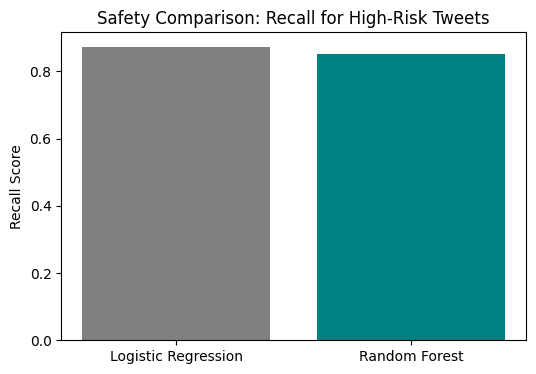

<Figure size 640x480 with 0 Axes>

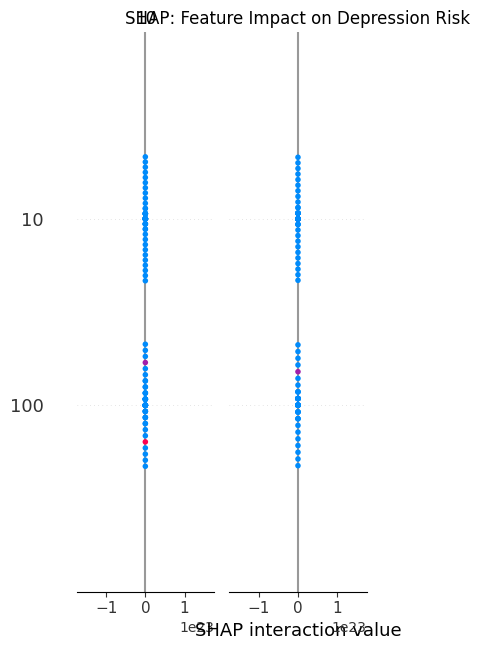

In [284]:
if __name__ == "__main__":
    run_pipeline()